In [1]:
import os,sys
import numpy as np
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu
import PIL
from PIL import Image
import sklearn
import h5py
from sklearn import svm

Using TensorFlow backend.


In [2]:
import keras
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.utils import np_utils

In [42]:
def runLinSVMModel(dataset,C,nDataset,modeltype,printReports=True,gamma=None):
    x_train = dataset['x_train']
    y_train = dataset['y_train']
    x_test = dataset['x_test']
    y_test = dataset['y_test']
    
    # Scaling training and test data
    means = np.mean(x_train,axis=0)
    stddev = np.std(x_train,axis=0)
    # Preventing zero division
    stddev[stddev<1e-3] = 1
    x_train = (x_train - means)/stddev
    x_test = (x_test - means)/stddev
    
    if modeltype=='linSVM':
        lin_clf = svm.LinearSVC(C=C/nDataset,verbose=True,class_weight='balanced')
        lin_clf.fit(x_train, y_train)
        pred_train = lin_clf.predict(x_train)
        pred_test = lin_clf.predict(x_test)
    elif modeltype=='linSVR':
        lin_clf = svm.LinearSVC(C=C/nDataset,verbose=True)
        lin_clf.fit(x_train, y_train)
        pred_train = np.round(lin_clf.predict(x_train))
        pred_test = np.round(lin_clf.predict(x_test))
    elif modeltype=='rbfSVM':
        lin_clf = svm.SVC(C=C/nDataset,gamma=gamma,verbose=True,class_weight='balanced',
                          decision_function_shape='ovr')
        lin_clf.fit(x_train, y_train)
        pred_train = lin_clf.predict(x_train)
        pred_test = lin_clf.predict(x_test)

    train_report = sklearn.metrics.classification_report(y_train,pred_train)
    test_report = sklearn.metrics.classification_report(y_test,pred_test)

    train_confmat = sklearn.metrics.confusion_matrix(y_train,pred_train)
    test_confmat = sklearn.metrics.confusion_matrix(y_test,pred_test)
    
    if printReports:
        print train_report
        print train_confmat
        print test_report
        print test_confmat

        print("Classification accuracy: %0.2f" % sklearn.metrics.accuracy_score(y_test,pred_test) )
        print("MSE: %0.2f" % np.mean(np.square(y_test - lin_clf.predict(x_test))) )
        print("Predictions correlation: %0.2f") % np.corrcoef(y_test,pred_test,rowvar=0)[0,1]
    
    result = {'train_report':train_report,'train_confmat':train_confmat,
             'test_report':test_report,'test_confmat':test_confmat,
             'train_score':lin_clf.score(x_train,y_train),
             'test_score':lin_clf.score(x_test,y_test) }
    return result

# Models on full dataset - 7 classes

## Load in the activations dataset

In [3]:
## Read in all files from directory and combine them into train/val/test datasets
dataset = cu.datautils.loadDataset("data/activations-4-19.h5")

Dim of data: 114688
Number of training images = 11484
Number of validation images = 3000
Number of test images = 1500
Distribution in training images: 
0 - 1472 
1 - 1430 
2 - 1431 
3 - 2871 
4 - 1455
Distribution in validation images: 
0 - 348 
1 - 387 
2 - 406 
3 - 742 
4 - 363
Distribution in test images: 
0 - 178 
1 - 182 
2 - 160 
3 - 382 
4 - 180


In [3]:

## Loading in and preparing datasets
x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']
num_val = dataset['x_val'].shape[0]
num_test = dataset['x_test'].shape[0]
nb_classes = 7

# Scaling training and test data
means = np.mean(x_train,axis=0)
stddev = np.std(x_train,axis=0)
# Preventing zero division
stddev[stddev<1e-3] = 1
x_train = (x_train - means)/stddev
x_val = (x_val - means)/stddev
x_test = (x_test - means)/stddev

# input shape
act_shape = x_train[0].shape
num_train = x_train.shape[0]

# Creating full input vectors 
X_train = np.reshape(x_train,(num_train,)+act_shape)
X_val = np.reshape(x_val,(num_val,)+act_shape)
X_test = np.reshape(x_test,(num_test,)+act_shape)

# convert class vectors to binary class matrices
# y_train = np.reshape(y_train,(num_train,))
# y_val = np.reshape(y_val,(num_val,))
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Dim of data: 114688
Number of training images = 11484
Number of validation images = 3000
Number of test images = 1500
Distribution in training images: 
0 - 1472 
1 - 1430 
2 - 1431 
3 - 2871 
4 - 1455
Distribution in validation images: 
0 - 348 
1 - 387 
2 - 406 
3 - 742 
4 - 363
Distribution in test images: 
0 - 178 
1 - 182 
2 - 160 
3 - 382 
4 - 180


/home/akashmjn/anaconda2/envs/cs341/lib/python2.7/site-packages/keras/utils/np_utils.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


In [4]:
dataset.keys()

['train_ids',
 'x_val',
 'x_train',
 'y_train',
 'val_ids',
 'y_val',
 'x_test',
 'y_test',
 'test_ids']

In [12]:
a = runLinSVMModel(dataset,1e-2,len(y_train),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       0.34      0.99      0.50      1472
        1.0       0.88      0.58      0.70      1430
        2.0       0.70      0.71      0.70      1431
        3.0       0.93      0.62      0.75      2871
        4.0       0.98      0.60      0.75      1455
        5.0       0.86      0.56      0.67      1434
        6.0       0.77      0.57      0.65      1391

avg / total       0.80      0.66      0.68     11484

[[1464    4    0    0    0    1    3]
 [ 417  830   93   53    7    5   25]
 [ 328    7 1018   59    1    7   11]
 [ 710   26  298 1787    2   17   31]
 [ 372   58   48    8  875   11   83]
 [ 547    6    1    5    0  796   79]
 [ 496    8    0    2    8   91  786]]
             precision    recall  f1-score   support

        0.0       0.30      0.98      0.46       178
        1.0       0.68      0.45      0.54       182
        2.0       0.50      0.61      0.55       160
        3.0       0.84      0

In [13]:
(a['train_score'],a['test_score'])

(0.65795889933820972, 0.51066666666666671)

## Evaluate saved models

In [4]:
valPred = cu.modelutils.evaluateSavedModel(\
                        "./savedModels/Class_2048_8x8_resampled_rmsproplr1e-05decay1e-06.hdf5",dataset,mode='val')

3000/3000 [==============================] - 21s    

Printing results on val dataset for best saved model: 

             precision    recall  f1-score   support

        0.0       0.38      0.75      0.51       348
        1.0       0.53      0.44      0.48       387
        2.0       0.55      0.45      0.49       406
        3.0       0.62      0.65      0.63       742
        4.0       0.67      0.53      0.59       363
        5.0       0.53      0.39      0.45       370
        6.0       0.46      0.38      0.42       384

avg / total       0.55      0.53      0.53      3000

[[261  13   2  42   8   8  14]
 [ 73 171  29  64  33   8   9]
 [ 59  18 182 126  12   2   7]
 [ 92  28  99 481   8  11  23]
 [ 40  51  13  26 194  11  28]
 [ 88  15   1  23   8 146  89]
 [ 69  29   4  20  28  87 147]]
Test accuracy: 0.53 


In [5]:
testPred = cu.modelutils.evaluateSavedModel(\
                        "./savedModels/Class_2048_8x8_resampled_rmsproplr1e-05decay1e-06.hdf5",dataset,mode='test')

1500/1500 [==============================] - 10s    

Printing results on test dataset for best saved model: 

             precision    recall  f1-score   support

        0.0       0.39      0.76      0.52       178
        1.0       0.49      0.49      0.49       182
        2.0       0.47      0.51      0.49       160
        3.0       0.66      0.68      0.67       382
        4.0       0.66      0.47      0.55       180
        5.0       0.49      0.33      0.40       193
        6.0       0.45      0.31      0.37       225

avg / total       0.54      0.52      0.52      1500

[[135   9   4  15   3   3   9]
 [ 27  89  18  24  13   4   7]
 [ 14  11  81  44   5   2   3]
 [ 38  16  57 259   2   3   7]
 [ 22  35   2  16  85   5  15]
 [ 52  13   2  14   4  64  44]
 [ 57   7   7  18  17  49  70]]
Test accuracy: 0.52 


In [8]:
dataset['val_ids'][10]

'006016'

In [15]:
## Saving misclassifications
imgPath = "./data/specdataimages/"
savePath = "./data/misclassifications-4-22-c1/"
os.system("mkdir -p {}".format(savePath))
for i in range(len(valPred)):
    if valPred[i] == 1 and dataset['y_val'][i] != 1:
        imgid = dataset['val_ids'][i]
        source = "{}{}.jpg".format(imgPath,imgid)
        dest = "{}p{}c{}_{}.jpg".format(savePath,0,int(dataset['y_val'][i]),imgid)
        os.system("cp {} {}".format(source,dest))

Manually examining the images above shows that the model has not been trained properly since the false predictions don't seem very consistent. 

## Some dimension reduction

In [14]:
x_train.shape

(11484, 114688)

With a fully connected network of size 2048, this would mean ~ 250M parameters (2048*114688) ~ 900-1800 MB memory depending on 4/8 byte float/double precision. This would be a super wasteful model, but we could quickly try it out. 

# Models on subset of classes - 4 classes

## Load in a subset of all classes 

In [3]:
# Loading in a dataset with a subset of all classes
subsetClasses = {0.0:0.0,2.0:1.0,3.0:2.0,5.0:3.0}
dataset = cu.datautils.loadDataset("data/activations-4-19.h5",subsetClasses=subsetClasses)

Dim of data: 114688
Number of training images = 7208
Number of validation images = 1866
Number of test images = 913
Distribution in training images: 
0 - 1472 
1 - 1431 
2 - 2871 
3 - 1434 
4 - 0
Distribution in validation images: 
0 - 348 
1 - 406 
2 - 742 
3 - 370 
4 - 0
Distribution in test images: 
0 - 178 
1 - 160 
2 - 382 
3 - 193 
4 - 0


In [7]:
## Loading in and preparing datasets
x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']
num_val = dataset['x_val'].shape[0]
num_test = dataset['x_test'].shape[0]
nb_classes = 4

In [43]:
## Parameter search for SVM
C_values = 10**np.random.uniform(-3,0,10)
train_scores = []
test_scores = []
for C_val in C_values:
    a = runLinSVMModel(dataset,C_val,len(dataset['y_train']),printReports=False,modeltype='linSVM')
    train_scores.append(a['train_score'])
    test_scores.append(a['test_score'])
    print "Results for C={}:".format(C_val)
    print "Train score={}   Test score={}".format(a['train_score'],a['test_score'])

[LibLinear]Results for C=0.222790438351:
Train score=0.912319644839   Test score=0.641840087623
[LibLinear]Results for C=0.0362072090501:
Train score=0.770394006659   Test score=0.641840087623
[LibLinear]Results for C=0.0284021322318:
Train score=0.758601553829   Test score=0.640744797371
[LibLinear]Results for C=0.197404914899:
Train score=0.90038845727   Test score=0.642935377875
[LibLinear]Results for C=0.0686468555717:
Train score=0.806742508324   Test score=0.638554216867
[LibLinear]Results for C=0.137560522679:
Train score=0.865566037736   Test score=0.646221248631
[LibLinear]Results for C=0.00115829981082:
Train score=0.628884572697   Test score=0.587075575027
[LibLinear]Results for C=0.0220883821024:
Train score=0.749306326304   Test score=0.641840087623
[LibLinear]Results for C=0.0913307970071:
Train score=0.829495005549   Test score=0.638554216867
[LibLinear]Results for C=0.0170282619001:
Train score=0.738623751387   Test score=0.642935377875


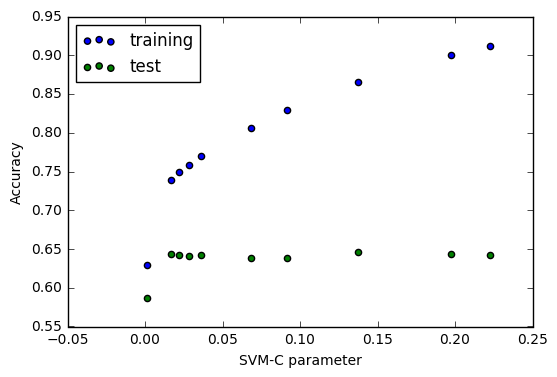

In [69]:
fname = "block5act_linSVM"
np.save("./plots/{}.npy".format(fname),np.column_stack([C_values,train_scores,test_scores]))
plt.scatter(C_values,train_scores,c='b',label='training')
plt.scatter(C_values,test_scores,c='g',label='test')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('SVM-C parameter')
plt.savefig("./plots/{}.png".format(fname))
plt.show()

In [16]:
a = runLinSVMModel(dataset,1e-1,len(dataset['y_train']),modeltype='linSVM')

[LibLinear]             precision    recall  f1-score   support

        0.0       0.57      1.00      0.73      1472
        1.0       0.96      0.86      0.91      1431
        2.0       1.00      0.77      0.87      2871
        3.0       0.98      0.78      0.87      1434

avg / total       0.90      0.84      0.85      7208

[[1472    0    0    0]
 [ 197 1234    0    0]
 [ 594   45 2213   19]
 [ 319    0    0 1115]]
             precision    recall  f1-score   support

        0.0       0.48      0.98      0.64       178
        1.0       0.52      0.63      0.57       160
        2.0       0.87      0.54      0.67       382
        3.0       0.89      0.53      0.66       193

avg / total       0.73      0.64      0.64       913

[[174   0   0   4]
 [ 27 101  31   1]
 [ 77  90 207   8]
 [ 87   3   1 102]]
Classification accuracy: 0.64
MSE: 1.42
Predictions correlation: 0.48


In [17]:
(a['train_score'],a['test_score'])

(0.83712541620421754, 0.63964950711938662)

In [40]:
10**np.random.uniform(-3,0,10)

array([ 0.0893849 ,  0.38330458,  0.00176971,  0.01411343,  0.76550141,
        0.00129565,  0.03611266,  0.00715768,  0.00149729,  0.11242027])